In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
""" adaptive forward and inverse """

' adaptive forward and inverse '

In [3]:
def wgh(k0, n_l, n_h):
    array = np.arange(n_l, n_h + 1)
    i0 = array[array != k0].astype(np.float64)
    return np.prod((i0 + 0.5) / (i0 - k0))

def D_correction(idx, n, s, N_range):
    N_range_corr = idx + s * (2 * N_range + 1)
    N_range_corr = N_range_corr + min(0, N_range_corr[0]) - \
                    N_range_corr[0]
    N_range_corr = N_range_corr + max(n-1, N_range_corr[-1]) - \
                    N_range_corr[-1]
    N_range_corr = ((N_range_corr[N_range_corr>=0] - idx) / s - 1.) / 2.
    return N_range_corr.astype(np.float64)

def C_correction(idx, n, s, N_range):
    N_range_corr = idx + s * (2 * N_range + 1)
    N_range_corr = N_range_corr + min(s-1, N_range_corr[0]) - \
                    N_range_corr[0]
    N_range_corr = N_range_corr + max(n-s-1, N_range_corr[-1]) - \
                    N_range_corr[-1]
    N_range_corr = ((N_range_corr[N_range_corr>=0]-idx)/s-1.)/2.
    return N_range_corr.astype(np.float64)

def forward_wtf(y_, jlvl, order_p, order_u, L_in):
    ende = len(y_)
    n_range_p = np.arange(-int((order_p+1)/2.), \
                          order_p-int((order_p+1)/2.)+1)
    n_range_u = np.arange(-int((order_u+1)/2.), \
                          order_u-int((order_u+1)/2.)+1)
    y_[L_in==False] = 0.
    
    for j in range(jlvl-2, -1, -1):
        s = 2**(jlvl - j - 1)
        
        D_idx = np.arange(s, ende, 2*s)
        C_idx = np.arange(0, ende, 2*s)
        
        # predict
        for i in D_idx:
            range_corr = D_correction(i, ende, s, n_range_p)
            order_corr = len(n_range_p) - 1
            for k in range(order_corr + 1):
                y_[i] = y_[i] - y_[int(i+(2*range_corr[k]+1)*s)] * \
                        wgh(range_corr[k], range_corr[0], range_corr[-1])
                
        # update
        for i in C_idx:
            range_corr = C_correction(i, ende, s, n_range_u)
            order_corr = len(n_range_u) - 1
            for k in range(order_corr):
                y_[i] = y_[i] + 0.5 * y_[int(i+(2*range_corr[k]+1)*s)] * \
                        wgh(range_corr[k], range_corr[0], range_corr[-1])
            
    return y_

def inverse_wtf(y_, jlvl, order_p, order_u, L_in):
    ende = len(y_)
    n_range_p = np.arange(-int((order_p+1)/2.), \
                          order_p-int((order_p+1)/2.)+1)
    n_range_u = np.arange(-int((order_u+1)/2.), \
                          order_u-int((order_u+1)/2.)+1)
    y_[L_in==False] = 0.
    
    for j in range(0, jlvl-1):
        s = 2**(jlvl - j - 1)
        
        D_idx = np.arange(s, ende, 2*s)
        C_idx = np.arange(0, ende, 2*s)
        
        # update
        for i in C_idx:
            range_corr = C_correction(i, ende, s, n_range_u)
            order_corr = len(n_range_u) - 1
            for k in range(order_corr + 1):
                y_[i] = y_[i] + y_[int(i+(2*range_corr[k]+1)*s)] * \
                        wgh(range_corr[k], range_corr[0], range_corr[-1])
                
        # predict
        for i in D_idx:
            range_corr = D_correction(i, ende, s, n_range_p)
            order_corr = len(n_range_p) - 1
            for k in range(order_corr):
                y_[i] = y_[i] + 0.5 * y_[int(i+(2*range_corr[k]+1)*s)] * \
                        wgh(range_corr[k], range_corr[0], range_corr[-1])
            
    return y_

In [4]:
def get_significant(y_, L, eps0, jlvl):
    ende = len(y_)
    L_sig = np.zeros((ende,), dtype=bool)
    y_[L==False] = 0.
    
    for j in range(jlvl-1, 0, -1):
        s = 2**(jlvl-j-1)
        
        D_idx = np.arange(s, ende, 2*s)
        C_idx = np.arange(0, ende, 2*s)
        
        D_idx = D_idx[copy.deepcopy(L[D_idx])]
        C_idx = C_idx[copy.deepcopy(L[C_idx])]
        
        L_sig[D_idx] = copy.deepcopy((np.abs(y_[D_idx])>=eps0) | \
                                    (L_sig[D_idx]==True))
        if j == 1:
            L_sig[C_idx] = True
            
    return L_sig

def adjust_lvl(y_in, L_in, jlvl_in, jmax, x_new):
    ende = len(y_in)
    D_now = np.zeros((jvlv_in,), dtype=bool)
    D_now[0] = True
    for j in range(0, jlvl-1):
        s = 2**(jlvl_in-j-1)
        D_idx = np.arange(s, ende, 2*s)
        D_now[j+1] = np.sum(L_in[D_idx] > 0.)
        
    D_now = copy.deepcopy(D_now)
    max_nonzero = copy.deepcopy(max([k0 for k0,k in enumerate(D_now) \
                                    if k is True]))
    jlvl_out = max_nonzero + 1
    
    y_out, L_out, x_new_out = [], [], []
    if jlvl_out > jlvl_in:
        s = 2**(jlvl_out - jlvl_in)
        nprd = ende % 2
        ende = int(s * (ende - nprd) + nprd)
        y_out = np.zeros((ende,), dtype=np.float64)
        L_out = np.zeros((ende,), dtype=bool)
        x_out_new = np.zeros((ende,), dtype=np.float64)
        
        C_idx = np.arange(0, ende, s)
        
        y_out[C_idx] = copy.deepcopy(y_in)
        L_out[C_idx] = copy.deepcopy(L_in)
        x_out_new[C_idx] = copy.deepcopy(x_new)
    elif jlvl_in == jlvl_out:
        y_out = copy.deepcopy(y_in)
        L_out = copy.deepcopy(L_in)
        x_out_new = copy.deepcopy(x_new)
    elif jlvl_out < jlvl_in:
        s = 2**(jlvl_in - jlvl_out)
        C_idx = np.arange(0, ende, s)
    
        nprd = ende % 2
        ende = int((ende - nprd) / s + nprd)
        y_out = np.zeros((ende,), dtype=np.float64)
        L_out = np.zeros((ende,), dtype=bool)
        x_out_new = copy.deepcopy(x_new[C_idx])
        
    return y_out, L_out, jlvl_out, x_out_new

def adjust_lvl_increase(y_in, L_in, jlvl_in, jmax, delta_jlvl):
    ende = len(y_in)
    D_now = np.zeros((jlvl_in,), dtype=bool)
    D_now[0] = True
    for j in range(0, jlvl-1):
        s = 2**(jlvl_in-j-1)
        D_idx = np.arange(s, ende, 2*s)
        print(ende)
        D_now[j+1] = np.sum(L_in[D_idx]) > 0

    print(D_now)
    D_now = copy.deepcopy(D_now)
    max_nonzero = copy.deepcopy(max([k0 for k0,k in enumerate(D_now) \
                                     if k == True]))
    jlvl_out = [jlvl][:][0]
    #max_nonzero + 1 #max(jlvl_in-1, min(max_nonzero+1, jmax))
    jlvl_out += delta_jlvl
    
    y_out, L_out = [], []
    if jlvl_out > jlvl_in:
        s = 2**(jlvl_out - jlvl_in)
        nprd = ende % 2
        ende = int(s * (ende - nprd) + nprd)
        y_out = np.zeros((ende,), dtype=np.float64)
        L_out = np.zeros((ende,), dtype=bool)
        x_out_new = np.zeros((ende,), dtype=np.float64)
        
        C_idx = np.arange(0, ende, s)
        
        y_out[C_idx] = copy.deepcopy(y_in)
        L_out[C_idx] = copy.deepcopy(L_in)
        #x_out_new[C_idx] = [] # we suppose, that initially we only compress the data
        
    elif jlvl_out == jlvl_in:
        y_out = copy.deepcopy(y_in)
        L_out = copy.deepcopy(L_in)
        C_idx = np.arange(0, ende, s)
    elif jlvl_out < jlvl_in:
        s = 2**(jlvl_in - jlvl_out)
        C_idx = np.arange(0, ende, s)
        
        nprd = ende % 2
        ende = int((ende - nprd) / s + nprd)
        y_out = np.zeros((ende,), dtype=np.float64)
        L_out = np.zeros((ende,), dtype=bool)
        x_out_new = np.zeros((ende,), dtype=np.float64)
        
        y_out = copy.deepcopy(y_in[C_idx])
        L_out = copy.deepcopy(L_in[C_idx])
        
    return y_out, L_out, jlvl_out, copy.deepcopy(C_idx)


def add_adjacent(L_in, jlvl):
    ende = len(L_in)
    L_adj = copy.deepcopy(L_in)
    
    for j in range(jlvl-1, -1, -1):
        s = 2**(jlvl - j)
        
        S_idx = []
        if j == 0:
            S_idx = np.arange(0, ende, s)
        else:
            S_idx = np.arange(s, ende, 2*s)
        S_idx = S_idx[L_in[S_idx]==True]
        
        if len(S_idx) > 0:
            coeff = 2**(min(j+1, jlvl) - j)
            coeff = np.array([-1, 1]) * s / coeff
            for ik in coeff:
                true_idx = (S_idx + ik >= 0) & (S_idx + ik < ende)
                L_adj[S_idx[true_idx==True] + int(ik)] = True
    return copy.deepcopy(L_adj)

In [614]:
############################### TEST 4 ##################################
# forward adaptive - inverse adaptive too
def adapt_grid_t4(y_, jlvl, jmax, order_p, order_u, eps):
    # forward - adaptive
    eps0 = copy.deepcopy(eps * np.max(np.abs(y_)))
    L = np.ones((len(y_),), dtype=bool)
    L_sig = get_significant(copy.deepcopy(y_), L, eps0, jlvl)
    
    y_new = copy.deepcopy(y_)
    y_out, L_sig, jlvl_new, C_idx = adjust_lvl_increase(y_new, \
                   L_sig, jlvl, jmax, delta_jlvl=3)
    L_sig = add_adjacent(L_sig, jlvl_new)

    y_new = forward_wtf(copy.deepcopy(y_out), jlvl_new, order_p, order_u, L_sig)

    # inverse - full
    L_final = np.ones((len(y_new),), dtype=bool)
    y_out0 = inverse_wtf(copy.deepcopy(y_new), jlvl_new, order_p, order_u, L_final)
    return y_out0, C_idx

4097
4097
4097
4097
4097
4097
4097
[ True  True  True  True  True  True  True  True]
32769 4097
0.0 2.1084395886461046e-81
4097
4097
4097
4097
4097
4097
4097
[ True  True  True  True  True  True  True  True]
32769 4097
1e-07 9.889908127124398e-08
4097
4097
4097
4097
4097
4097
4097
[ True  True  True  True  True  True  True  True]
32769 4097
1e-06 9.547606075834836e-07
4097
4097
4097
4097
4097
4097
4097
[ True  True  True  True  True  True  True  True]
32769 4097
1e-05 9.17330534245643e-06
4097
4097
4097
4097
4097
4097
4097
[ True  True  True  True  True  True  True  True]
32769 4097
0.0001 9.718745177491704e-05
4097
4097
4097
4097
4097
4097
4097
[ True  True  True  True  True  True  True  True]
32769 4097
0.001 0.0008966833264088973
4097
4097
4097
4097
4097
4097
4097
[ True  True  True  True  True  True  True  True]
32769 4097
0.01 0.009387419938778717
4097
4097
4097
4097
4097
4097
4097
[ True  True  True  True  True  True  True  True]
32769 4097
0.1 0.09746066322029336


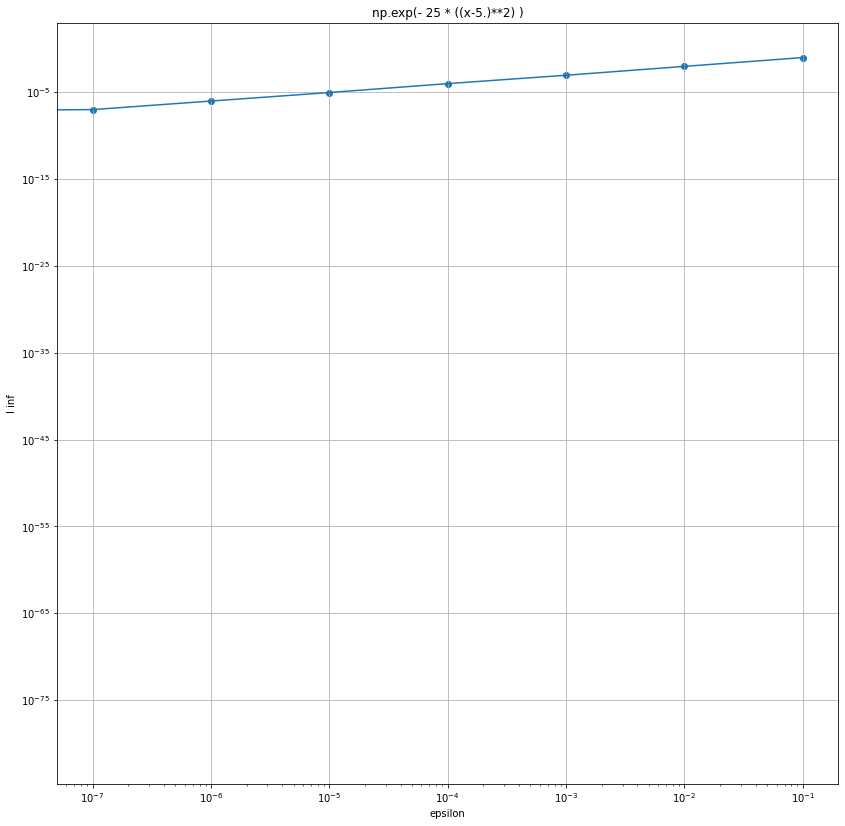

In [605]:
############################# TEST 4 ##########################################
x_ = np.arange(0., 10.001, 10./ 4096.)
func = lambda x: (np.sin(100.*x)*0. + \
                  np.exp(- 25. * ((x-5.)**2) )).astype(np.float64) 
y0_ = func(x_).astype(np.float64)
y_ = copy.deepcopy(y0_)

jlvl = 8
order_p = 3
order_u = 3
eps = 0.000001
jmx = 10

errs_1 = []
epsilons = np.array([0.]+list(10.**np.arange(-7, 0)))
for eps in ([0.] + list(10.**np.arange(-7, 0))):
    #(10**np.arange(-1., -8., -1.)).astype(np.float64):
    x_ = np.arange(0., 10.001, 10./ 4096.)
    #x_ = np.arange(0., 10.001, 10./ 1024.)
    func = lambda x: (np.sin(10.*x)*0. + \
                      np.exp(- 25. * ((x-5.)**2) )).astype(np.float64) 
    y0_ = func(x_).astype(np.float64)
    y_ = copy.deepcopy(y0_)

    #y_after, x_new0, ls_out, ls_out_y_new = adapt_grid_t4(y_, jlvl, jmx, order_p, order_u, eps)
    y_new, c_idx = adapt_grid_t4(y_, jlvl, jmx, order_p, order_u, eps)

    print(len(y_new), len(c_idx))
    errs_1.append(copy.deepcopy( np.max(np.abs(y_ - y_new[c_idx])) ))
    
    #errs_1.append(copy.deepcopy(np.max( np.abs(y_after[ls_out_y_new==True]-y0_[ls_out==True]) )))
    print(eps, np.max(np.abs(y_ - y_new[c_idx])))
    
plt.figure(figsize=(14,14))
plt.plot(epsilons, errs_1)
plt.scatter(epsilons, errs_1)
plt.xscale("log")
plt.yscale("log")
plt.title("np.exp(- 25 * ((x-5.)**2) )")
plt.xlabel("epsilon")
plt.ylabel("l inf")
plt.grid()

In [51]:
""" derivative """

' derivative '

In [615]:
def G_correction(idx, n, s, N_range):
    N_range_corr = idx + s * N_range
    N_range_corr = N_range_corr + max(0, N_range_corr[0]) - \
                    N_range_corr[0]
    N_range_corr = N_range_corr + min(n-1, N_range_corr[-1]) - \
                    N_range_corr[-1]
    N_range_corr = (N_range_corr[N_range_corr>=0]-idx) / s
    return N_range_corr.astype(np.float64)

"""=============================================="""
def dwgh(k, n_l, n_h,h):
    dwgh0 = 0.
    array = np.arange(n_l, n_h+1)
    i0 = array[array != k]
    for m in i0:
        dwgh0 = dwgh0 - np.prod(i0[i0 != m])

    denum = np.prod(i0-k)
    add = np.sign(denum) if denum != 0 else 1.
    dwgh0 = dwgh0 / (denum + 0.0000000001*add) / copy.deepcopy(h)
    return dwgh0

def df_pt(f, h, n_l, n_h):
    df = 0.0
    for j in range(n_l, n_h+1):
        df = df + f[j-n_l]*dwgh(j, n_l, n_h, h)
    return df
    
"""=============================================="""
def d2wgh(k, n_l, n_h, h):
    d2wgh0 = 0.
    array = np.arange(n_l, n_h+1)
    i0 = array[array != k]
    for m in i0:
        j = i0[i0!=m]
        for n in j:
            d2wgh0 = d2wgh0 + np.prod(j[j!=n])
    denum = np.prod(i0-k)
    add = np.sign(denum) if denum != 0 else 1.
    d2wgh0 = d2wgh0 / (denum + 0.0000000001*add) / copy.deepcopy(h**2)
    return d2wgh0
            

def d2f_pt(f, h, n_l, n_h):
    d2f = 0.0
    for j in range(n_l, n_h+1):
        d2f = d2f + f[j-n_l]*d2wgh(j, n_l, n_h, h)
    return d2f
    
"""=============================================="""
prd_corr = lambda ind,n: 1+(ind-1+n)%n

def calc_deriv(y_, L, jlvl, order_p, order_u, h, der_order):
    order = order_u
    ende = len(y_)
    j_df = np.ones((len(L),))
    j_df[L==False] = 0
    n_range = np.array([-1, 0])
    for j in range(1, jlvl):
        s = 2**(jlvl-j-1)
        D_ind = np.arange(0, ende, 2*s)
        D_ind = D_ind[L[D_ind]==True]
        j_df[D_ind] = j + 1
        
    for j in range(1, jlvl):
        s = 2**(jlvl-j-1)
        
        D_ind = np.arange(s, ende, 2*s)
        C_ind = np.arange(0, ende, 2*s)
        D_ind = D_ind[L[D_ind]==True]
        C_ind = C_ind[L[C_ind]==True]
        
        for i in D_ind:
            range_corr = G_correction(i, ende, s, n_range)
            for k in range(len(range_corr)):
                j_df[int(i+range_corr[k]*s)] = j + 1
                
    G = copy.deepcopy(L)
    n_range = np.arange(-int((der_order+1)/2.), \
                        int((der_order+1)/2.)+1)
    
    for j in range(1, jlvl+1):
        s = 2**(jlvl - j)
        G_ind = np.arange(0, ende, s)
        G_ind = G_ind[L[G_ind]==True]
        
        for i in G_ind[j==j_df[G_ind]]:
            range_corr = G_correction(i, ende, s, n_range)
            for k in range(len(range_corr)):
                G[int(i + range_corr[k] * s)] = True
                
    dF = np.zeros((len(L),))
    d2F = np.zeros((len(L),))
    
    Fn = forward_wtf(y_, jlvl, order_p, order_u, L)
    ende = len(L)
    n_range = np.arange(-int((order+1)/2), order-int((order+1)/2)+1)
    d_range = np.arange(-int((der_order+1)/2), \
                        der_order-int((der_order+1)/2)+1)
    
    for j in range(1, jlvl+1):
        s = 2**(jlvl - j)
        G_ind = np.arange(0, ende, s)
        G_ind = G_ind[L[G_ind]==True]
        
        for i in G_ind[j==j_df[G_ind]]:
            range_corr = G_correction(i, ende, s, d_range).astype(int)
            array_range = i+range_corr*s
            array_range = array_range.astype(int)
            dF[i] = df_pt(Fn[array_range], h*s, range_corr[0], \
                          range_corr[-1])
            d2F[i] = d2f_pt(Fn[array_range], h*s, range_corr[0], \
                          range_corr[-1])
        if j < jlvl:
            s = int(2**(jlvl-j-1))
            D_ind = np.arange(s, ende, 2*s)
            C_ind = np.arange(0, ende, 2*s)
            
            D_ind = D_ind[G[D_ind]==True]
            C_ind = C_ind[G[C_ind]==True]
            
            # update
            for i in C_ind:
                range_corr = C_correction(i, ende, s, n_range).astype(int)
                order_corr = len(range_corr) - 1
                for k in range(order_corr + 1):
                    y_[i] = y_[i] - 0.5*y_[int(i+(2*range_corr[k]+1)*s)] * \
                            wgh(range_corr[k], range_corr[0], range_corr[-1])

            # predict
            for i in D_ind:
                range_corr = D_correction(i, ende, s, n_range).astype(int)
                order_corr = len(range_corr) - 1
                for k in range(order_corr+1):
                    y_[i] = y_[i] + y_[int(i+(2*range_corr[k]+1)*s)] * \
                            wgh(range_corr[k], range_corr[0], range_corr[-1])
    return y_, dF, d2F

In [344]:
x_ = np.arange(0., 10.001, 10./ 4096.)
func = lambda x: (np.sin(100.*x)*0. + \
                  np.exp(- 25. * ((x-5.)**2) )).astype(np.float64) 
y0_ = func(x_).astype(np.float64)
y_ = copy.deepcopy(y0_)

jlvl = 8
order_p = 3
order_u = 3
eps = 0.000001
jmx = 10
der_order=3
L = np.ones((len(y_),), dtype=bool)
ende_ = 1+8*2**(jlvl-1)
h = 10. / (ende_-ende_%2)
errs_1 = []
y, df, d2f = calc_deriv(y_, L, jlvl, order_p, order_u, h, der_order)

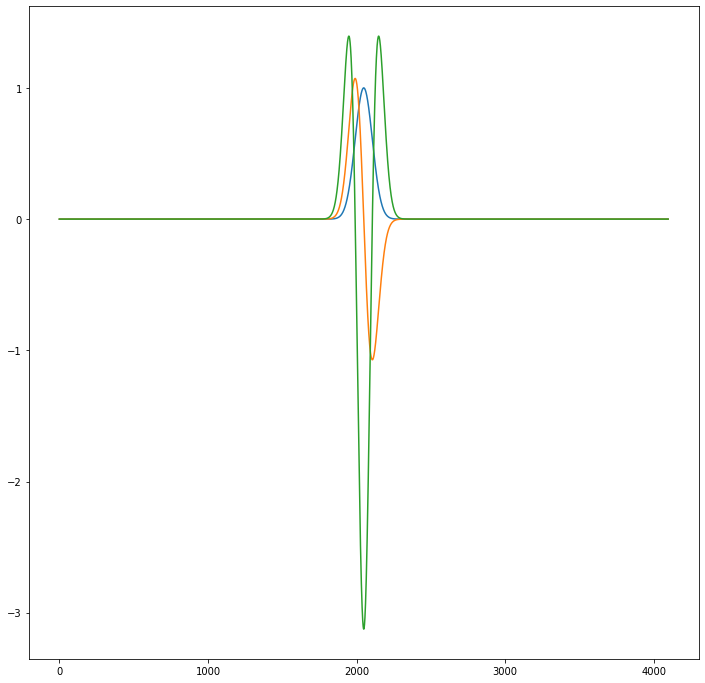

In [345]:
plt.figure(figsize=(12,12))
plt.plot(y)
plt.plot(df)
plt.plot(d2f)

In [170]:
""" derivative masking """

' derivative masking '

In [616]:
def add_ghost(L, jlvl, der_order):
    ende = len(L)
    j_df = np.ones((ende,), dtype=bool)
    j_df[L==False] = 0    
    n_range = np.array([-1, 0])
    
    for j in range(0, jlvl-1):
        s = 2**(jlvl-j-2)
        D_ind = np.arange(s, ende, 2*s)
        D_ind = D_ind[L[D_ind]==True]
        j_df[D_ind] = j + 1
        
    for j in range(0, jlvl-1):
        s = 2**(jlvl-j-2)
        
        D_ind = np.arange(s, ende, 2*s)
        C_ind = np.arange(0, ende, 2*s)
        D_ind = D_ind[L[D_ind]==True]
        C_ind = C_ind[L[C_ind]==True]
        
        for i in D_ind:
            range_corr = G_correction(i, ende, s, n_range)
            for k in range(len(range_corr)):
                j_df[int(i+range_corr[k]*s)] = j+1
    G = copy.deepcopy(L)
    n_range = np.arange(-int((der_order+1)/2), int((der_order+1)/2)+1)
    
    for j in range(0, jlvl):
        s = 2**(jlvl-j-1)
        
        G_ind = np.arange(0, ende, s)
        G_ind = G_ind[L[G_ind]==True]
        
        for i in G_ind[j==j_df[G_ind]]:
            range_corr = G_correction(i, ende, s, n_range)
            for k in range(len(range_corr)):
                G[int(i+range_corr[k]*s)] = True
    return G, j_df

In [617]:
def reconstruction_check(jlvl, order_p, L_in):
    ende = len(L_in)
    L_out = copy.deepcopy(L_in)
    n_range = np.arange(-int((order_p+1)/2), \
                        order_p-int((order_p+1)/2)+1)
    
    for j in np.arange(jlvl-2, -1, -1):
        s = 2.**(jlvl-j-2)
        
        D_ind = np.arange(s, ende, 2*s).astype(int)
        D_ind = D_ind[np.where(L_out[D_ind]==True)]
        
        for i in D_ind:
            n_range_corr = D_correction(i, ende, s, n_range)
            order_corr = len(n_range_corr) - 1
            for k in np.arange(order_corr + 1):
                L_out[int(i + (2*n_range_corr[k]+1)*s)] = \
                    L_out[int(i + (2*n_range_corr[k]+1)*s)] | L_out[int(i)]
                
    return L_out

def calc_derivative_mask(y_, L, G, j_df, jlvl, order, h, der_order):
    ende = len(L)
    jmax = jlvl
    dF = np.zeros((len(L),))
    d2F = np.zeros((len(L),))
    """
    Fn = forward_wtf(copy.deepcopy(y_), jlvl, order, order, L)
    """
    n_range = np.arange(-int((order+1)/2), order-int((order+1)/2)+1)
    d_range = np.arange(-int((der_order+1)/2), \
                        der_order-int((der_order+1)/2)+1)
    
    for j in range(0, jlvl):
        s = 2**(jlvl-j-1)
        G_ind = np.arange(0, ende, s)
        G_ind = G_ind[L[G_ind]==True]
        
        for i in G_ind[j==j_df[G_ind]]:
            range_corr = G_correction(i, ende, s, d_range).astype(int)
            array_range = i+range_corr*s
            array_range = array_range.astype(int)
            dF[i] = df_pt(y_[array_range], h*s, range_corr[0], \
                          range_corr[-1])
            d2F[i] = d2f_pt(y_[array_range], h*s, range_corr[0], \
                          range_corr[-1])
            
        if j < jlvl:
            s = int(2**(jlvl-j-2))
            D_ind = np.arange(s, ende, 2*s)
            C_ind = np.arange(0, ende, 2*s)
            
            D_ind = D_ind[G[D_ind]==True]
            C_ind = C_ind[G[C_ind]==True]
            
            # update
            for i in C_ind:
                range_corr = C_correction(i, ende, s, n_range).astype(int)
                order_corr = len(range_corr)
                for k in range(order_corr):
                    y_[i] = y_[i] - 0.5*y_[int(i+(2*range_corr[k]+1)*s)] * \
                            wgh(range_corr[k], range_corr[0], range_corr[-1])

            # predict
            for i in D_ind:
                N_range_corr = i + s * (2 * n_range + 1)
                N_range_corr = N_range_corr + min(0, N_range_corr[0]) - \
                                N_range_corr[0]
                N_range_corr = N_range_corr + max(ende-1, N_range_corr[-1]) - \
                                N_range_corr[-1]
                N_range_corr = ((N_range_corr[N_range_corr>=0] - i) / s - 1.) / 2
                range_corr = copy.deepcopy(N_range_corr)
                """
                range_corr = D_correction(i, ende, s, n_range).astype(int)
                """
                order_corr = len(range_corr)
                for k in range(order_corr):
                    y_[i] = y_[i] + y_[int(i+(2*range_corr[k]+1)*s)] * \
                            wgh(range_corr[k], range_corr[0], range_corr[-1])
    return y_, dF, d2F

In [618]:
""" perform calc derivative """
def calc_der(y_, L, jlvl, order_p, order_u, h, der_order, eps0):
    order = order_p
    jmax = jlvl
    scale = np.max(y_[L==True]) - np.min(y_[L==True])
    y_curr = forward_wtf(copy.deepcopy(y_), jlvl, order, \
                     order, L)
    
    L_sig = get_significant(copy.deepcopy(y_curr), L, eps0, jlvl)
    y_out, L_sig, jlvl_new, C_idx = adjust_lvl_increase(\
                    copy.deepcopy(y_curr), \
                   L_sig, jlvl, jmax, delta_jlvl=0)
    L_s = add_adjacent(L_sig, jlvl_new)
    L_n = reconstruction_check(jlvl_new, order, L_s)
    G, j_df = add_ghost(L_n, jlvl, order)
    """
    Fn = inverse_wtf(copy.deepcopy(y_out), jlvl_new, order, \
                     order, L)
    """
    F, dF, d2F = calc_derivative_mask(y_out, L_n, G, \
                                      j_df, jlvl, order, h, der_order)
    return F, dF, d2F

In [619]:
x_ = np.arange(0., 10.001, 10./ 4095.)
func = lambda x: (np.sin(100.*x)*0. + \
                  np.exp(- 25. * ((x-5.)**2) )).astype(np.float64) 
y0_ = func(x_).astype(np.float64)
y_ = copy.deepcopy(y0_)

jlvl = 8
order_p = 3
order_u = 3
der_order=3
L = np.ones((len(y_),), dtype=bool)
ende_ = 1+8*2**(jlvl-1)
h = 10. / (ende_-ende_%2)
errs_1 = []

for eps in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
    eps0 = np.max(np.abs(y_)) * eps
    y, df, d2f = calc_der(y_, L, jlvl, order_p, order_u, \
                          h, der_order, eps0)
    plt.plot(y)
    plt.plot(df)
    #plt.plot(d2f)
    plt.show()
    print(eps)

4096
4096
4096
4096
4096
4096
4096
[ True  True  True  True  True  True  True  True]


ZeroDivisionError: division by zero

In [580]:
""" ITERATION 1 """

' ITERATION 1 '

In [629]:
def add_ghost(Lg, jlvlg, orderg):
    ende = len(Lg)
    
    j_df = np.zeros((len(Lg),))
    j_df[Lg==False] = 0.
    n_range = np.array([-1, 0])
    for j in range(jlvlg-1, -1, -1):
        s = 2**(jlvlg-j-1)
        D_ind = np.arange(s, ende, 2*s)
        D_ind = D_ind[Lg[D_ind]==True]
        j_df[D_ind] = np.maximum(j, j_df[D_ind])
        
    for j in range(0, jlvlg-1):
        s = 2**(jlvlg-j-2)
        
        D_ind = np.arange(s, ende, 2*s)
        C_ind = np.arange(0, ende, 2*s)
        D_ind = D_ind[Lg[D_ind]==True]
        C_ind = C_ind[Lg[C_ind]==True]
        
        for ik in D_ind:
            range_corr = G_correction(ik, ende, s, copy.deepcopy(n_range))
            for k0 in range(len(range_corr)):
                j_df[int(ik+range_corr[k0]*s)] = j+1
            
    Gg = copy.deepcopy(Lg)
    n_range = np.arange(-int((der_order+1)/2.), int((der_order+1)/2.)+1)
    for j in range(0, jlvlg):
        s = 2**(jlvlg-j-1)
        G_ind = np.arange(0, ende, s)
        G_ind = G_ind[Lg[G_ind]==True]
        
        for ik in G_ind[j==j_df[G_ind]]:
            range_corr = G_correction(ik, ende, s, n_range)
            for k0 in range(len(range_corr)):
                Gg[int(ik+range_corr[k0]*s)] = True
    return Gg, j_df
        

def calc_deriv_m(yd, Ld, Gd, j_dfd, jlvld, orderd, hd, der_orderd):
    ende = len(Ld)
    dF = np.zeros((len(Ld),))
    d2F = np.zeros((len(Ld),))
    """
    Fn = forward_wtf(copy.deepcopy(yd), jlvld, orderd, orderd, Ld)
    """
    Fn = copy.deepcopy(yd)
    #Fn[Ld==False] = 0.
    n_range = np.arange(-int((orderd+1)/2.), \
                        orderd-int((orderd+1)/2.)+1)
    d_range = np.arange(-int((der_orderd+1)/2.), \
                        int((der_orderd+1)/2.)+1)
                
    
    for j in range(0, jlvld):
        s = 2**(jlvld-j-1)
        G_ind = np.arange(0, ende, s)
        G_ind = copy.deepcopy(G_ind[Ld[G_ind]==True])
        for ik in G_ind[j==j_dfd[G_ind]]:
            range_corr = G_correction(ik, ende, s, copy.deepcopy(d_range)).astype(int)
            array_idx = copy.deepcopy(ik + range_corr * s).astype(int)
            dF[ik] = df_pt(copy.deepcopy(Fn[array_idx]), h*s, \
                         copy.deepcopy(range_corr[0]), \
                          copy.deepcopy(range_corr[-1]))
            d2F[ik] = d2f_pt(copy.deepcopy(Fn[array_idx]), h*s, \
                         copy.deepcopy(range_corr[0]), \
                          copy.deepcopy(range_corr[-1]))
        
        if j < jlvld-1:
            s = 2**(jlvld-j-2)
            D_ind = np.arange(s, ende, 2*s)
            C_ind = np.arange(0, ende, 2*s)
            D_ind = D_ind[Gd[D_ind]==True]
            C_ind = C_ind[Gd[C_ind]==True]

            for i in C_ind:
                range_corr = C_correction(i, ende, s, n_range).astype(int)
                order_corr = len(range_corr)
                for k0 in range(order_corr):
                    Fn[i] = Fn[i] - 0.5*Fn[int(\
                            np.floor(i + (2*range_corr[k0]+1)*s))]*\
                            wgh(range_corr[k0], range_corr[0], range_corr[-1])
            for i in D_ind:
                range_corr = D_correction(i, ende, s, \
                                copy.deepcopy(n_range))
                order_corr = len(range_corr)
                for k0 in range(order_corr):
                    Fn[i] = Fn[i] + Fn[int(\
                            np.floor(i + (2*range_corr[k0]+1)*s))]*\
                            wgh(range_corr[k0], range_corr[0], range_corr[-1])
    return Fn, dF, d2F

In [630]:
""" perform calc derivative """
def calc_der(y_, L, jlvl, order_p, order_u, h, der_order, eps0):
    order = order_p
    jmax = jlvl
    scale = np.max(y_[L==True]) - np.min(y_[L==True])
    y_curr = forward_wtf(copy.deepcopy(y_), jlvl, order, \
                     order, L)
    
    L_sig0 = get_significant(copy.deepcopy(y_curr), L, eps0, jlvl)
    """
    y_out, L_sig, jlvl_new, C_idx = adjust_lvl_increase(\
                    copy.deepcopy(y_curr), \
                   L_sig, jlvl, jmax, delta_jlvl=0)
    """
    y_out, L_sig1, jlvl_new, C_idx = adjust_lvl_increase(\
                    copy.deepcopy(y_curr), \
                   copy.deepcopy(L_sig0), jlvl, jmax, 0)
    L_s = add_adjacent(copy.deepcopy(L_sig1), jlvl_new)
    L_n = reconstruction_check(jlvl_new, order, copy.deepcopy(L_s))
    G, j_df = add_ghost(L_n, jlvl_new, order)
    L_n1 = reconstruction_check(jlvl_new, order, copy.deepcopy(G))
    """
    Fn = inverse_wtf(copy.deepcopy(y_out), jlvl_new, order, \
                     order, L_n)
    """
    F, dF, d2F = calc_deriv_m(copy.deepcopy(y_out), L_n, L_n1, \
                            j_df, jlvl_new, order, h, der_order)
    return F, dF, d2F

4096
4096
4096
4096
4096
4096
4096
[ True  True  True  True  True  True  True  True]
[  64  192  320  448  576  704  832  960 1088 1216 1344 1472 1600 1728
 1856 1984 2112 2240 2368 2496 2624 2752 2880 3008 3136 3264 3392 3520
 3648 3776 3904 4032] 64
[  32   96  160  224  288  352  416  480  544  608  672  736  800  864
  928  992 1056 1120 1184 1248 1312 1376 1440 1504 1568 1632 1696 1760
 1824 1888 1952 2016 2080 2144 2208 2272 2336 2400 2464 2528 2592 2656
 2720 2784 2848 2912 2976 3040 3104 3168 3232 3296 3360 3424 3488 3552
 3616 3680 3744 3808 3872 3936 4000 4064] 32
[  16   48   80  112  144  176  208  240  272  304  336  368  400  432
  464  496  528  560  592  624  656  688  720  752  784  816  848  880
  912  944  976 1008 1040 1072 1104 1136 1168 1200 1232 1264 1296 1328
 1360 1392 1424 1456 1488 1520 1552 1584 1616 1648 1680 1712 1744 1776
 1808 1840 1872 1904 1936 1968 2000 2032 2064 2096 2128 2160 2192 2224
 2256 2288 2320 2352 2384 2416 2448 2480 2512 2544 2576 2608 264

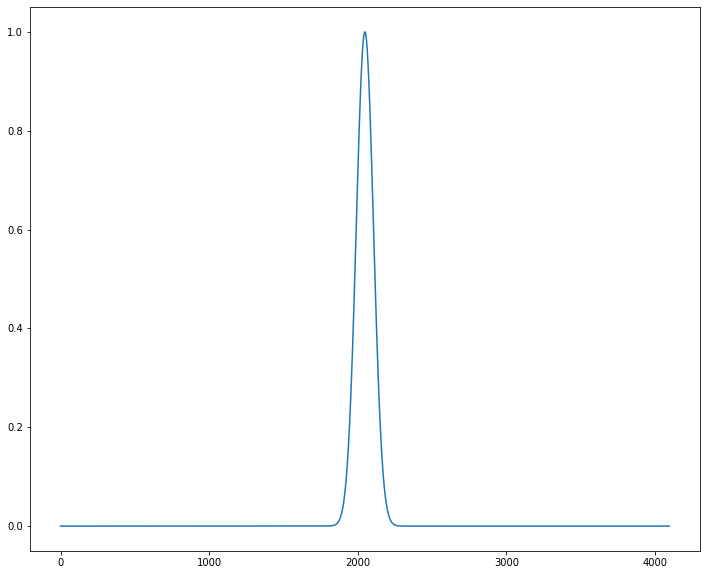

0.01
4096
4096
4096
4096
4096
4096
4096
[ True  True  True  True  True  True  True  True]
[  64  192  320  448  576  704  832  960 1088 1216 1344 1472 1600 1728
 1856 1984 2112 2240 2368 2496 2624 2752 2880 3008 3136 3264 3392 3520
 3648 3776 3904 4032] 64
[  32   96  160  224  288  352  416  480  544  608  672  736  800  864
  928  992 1056 1120 1184 1248 1312 1376 1440 1504 1568 1632 1696 1760
 1824 1888 1952 2016 2080 2144 2208 2272 2336 2400 2464 2528 2592 2656
 2720 2784 2848 2912 2976 3040 3104 3168 3232 3296 3360 3424 3488 3552
 3616 3680 3744 3808 3872 3936 4000 4064] 32
[  16   48   80  112  144  176  208  240  272  304  336  368  400  432
  464  496  528  560  592  624  656  688  720  752  784  816  848  880
  912  944  976 1008 1040 1072 1104 1136 1168 1200 1232 1264 1296 1328
 1360 1392 1424 1456 1488 1520 1552 1584 1616 1648 1680 1712 1744 1776
 1808 1840 1872 1904 1936 1968 2000 2032 2064 2096 2128 2160 2192 2224
 2256 2288 2320 2352 2384 2416 2448 2480 2512 2544 2576 260

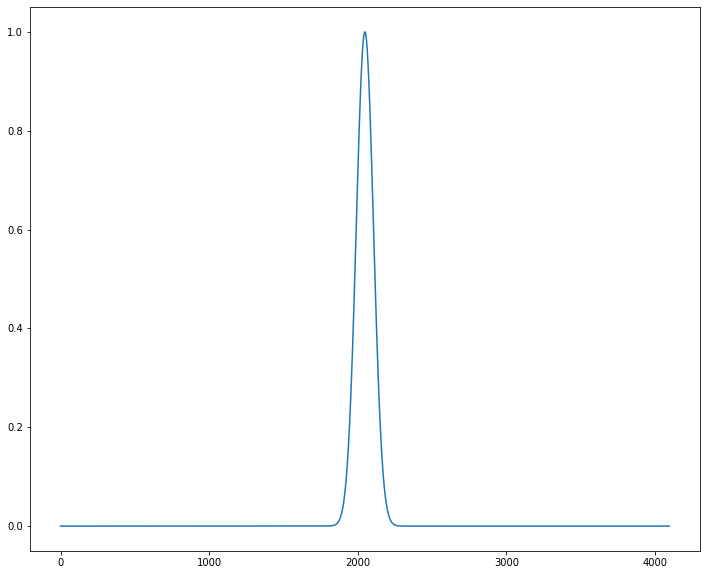

0.1


In [631]:
x_ = np.arange(0., 10.001, 10./ 4095.)
func = lambda x: (np.sin(100.*x)*0. + \
                  np.exp(- 25. * ((x-5.)**2) )).astype(np.float64) 
y0_ = func(x_).astype(np.float64)
y_ = copy.deepcopy(y0_)

jlvl = 8
order_p = 3
order_u = 3
der_order=3
L = np.ones((len(y_),), dtype=bool)
ende_ = 1+8*2.**(jlvl-1)
h = 10. / (ende_-ende_%2)
errs_1 = []

#for eps in [0., 0.00001, 0.0001, 0.001, 0.01, 0.1]:
for eps in [0.01, 0.1]:
    eps0 = np.max(np.abs(y_)) * eps
    y, df, d2f = calc_der(y_, L, jlvl, order_p, order_u, \
                          h, der_order, eps0)
    plt.figure(figsize=(12,10))
    plt.plot(y)
    #[1800:2200])
    #plt.plot(df[1800:2200])
    #plt.plot(d2f[1800:2200])
    plt.show()
    print(eps)

In [632]:
""" ITERATION 2 """

' ITERATION 2 '

In [5]:
def G_correction(idx, n, s, N_range):
    N_range_corr = idx + s * N_range
    N_range_corr = N_range_corr + max(0, N_range_corr[0]) - \
                    N_range_corr[0]
    N_range_corr = N_range_corr + min(n-1, N_range_corr[-1]) - \
                    N_range_corr[-1]
    N_range_corr = (N_range_corr[N_range_corr>=0]-idx) / s
    return N_range_corr.astype(np.float64)

"""=============================================="""
def dwgh(k, n_l, n_h, h):
    dwgh0 = 0.
    array = np.arange(n_l, n_h+1)
    i0 = array[array != k]
    for m in i0:
        dwgh0 = dwgh0 - np.prod(i0[i0 != m])

    denum = np.prod(i0-k)
    #add = np.sign(denum) if denum != 0 else 1.
    dwgh0 = dwgh0 / denum / copy.deepcopy(h)
    return dwgh0

def df_pt(f, h, n_l, n_h):
    df = 0.0
    for j in range(n_l, n_h+1):
        df = df + f[j-n_l]*dwgh(j, n_l, n_h, h)
    return df
    
"""=============================================="""
def d2wgh(k, n_l, n_h, h_):
    d2wgh0 = 0.
    array = np.arange(n_l, n_h+1)
    i0 = array[array != k]
    for m in i0:
        j = i0[i0!=m]
        for n in j:
            d2wgh0 = d2wgh0 + np.prod(j[j!=n])
    denum = np.prod(i0-k)
    #add = np.sign(denum) if denum != 0 else 1.
    d2wgh0 = d2wgh0 / denum / copy.deepcopy(h_**2)
    return d2wgh0
            

def d2f_pt(f, h, n_l, n_h):
    d2f = 0.0
    for j in range(n_l, n_h+1):
        d2f = d2f + f[j-n_l]*d2wgh(j, n_l, n_h, h)
    return d2f

In [6]:
def wgh(k0, n_l, n_h):
    array = np.arange(n_l, n_h + 1)
    i0 = array[array != k0]
    return np.prod(i0 + 0.5) / np.prod(i0 - k0)

def D_correction(idx, n, s, N_range):
    N_range_corr = idx + s * (2 * N_range + 1)
    N_range_corr = N_range_corr + max(0, N_range_corr[0]) - \
                    N_range_corr[0]
    N_range_corr = N_range_corr + min(n-1, N_range_corr[-1]) - \
                    N_range_corr[-1]
    N_range_corr = ((N_range_corr[N_range_corr>=0] - idx) / s - 1.) / 2.
    return N_range_corr.astype(np.float64)

def C_correction(idx, n, s, N_range):
    N_range_corr = idx + s * (2 * N_range + 1)
    N_range_corr = N_range_corr + max(s-1, N_range_corr[0]) - \
                    N_range_corr[0]
    N_range_corr = N_range_corr + min(n-s-1, N_range_corr[-1]) - \
                    N_range_corr[-1]
    N_range_corr = ((N_range_corr[N_range_corr>=0]-idx)/s-1.)/2.
    return N_range_corr.astype(np.float64)

def forward_wtf(y_, jlvl, order_p, order_u, L_in):
    ende = len(y_)
    n_range_p = np.arange(-int((order_p+1)/2.), \
                          order_p-int((order_p+1)/2.)+1)
    n_range_u = np.arange(-int((order_u+1)/2.), \
                          order_u-int((order_u+1)/2.)+1)
    y_[L_in==False] = 0.
    
    for j in range(jlvl-2, -1, -1):
        s = 2**(jlvl - j - 2)
        D_idx = np.arange(s, ende, 2*s)
        C_idx = np.arange(0, ende, 2*s)
        
        # predict
        for i in D_idx:
            range_corr = np.floor(D_correction(i, ende, s, n_range_p))
            order_corr = len(n_range_p) - 1
            for k in range(order_corr + 1):
                y_[i] = y_[i] - y_[int(\
                        np.floor(i+(2*range_corr[k]+1)*s))] * \
                        wgh(range_corr[k], range_corr[0], range_corr[-1])
        # update
        for i in C_idx:
            range_corr = np.floor(C_correction(i, ende, s, n_range_u))
            order_corr = len(n_range_u) - 1
            for k in range(order_corr):
                y_[i] = y_[i] + 0.5 * y_[int(\
                        np.floor(i+(2*range_corr[k]+1)*s))] * \
                        wgh(range_corr[k], range_corr[0], range_corr[-1])
    return y_

def inverse_wtf(y_, jlvl, order_p, order_u, L_in):
    ende = len(y_)
    n_range_p = np.arange(-int((order_p+1)/2.), \
                          order_p-int((order_p+1)/2.)+1)
    n_range_u = np.arange(-int((order_u+1)/2.), \
                          order_u-int((order_u+1)/2.)+1)
    y_[L_in==False] = 0.
    
    for j in range(0, jlvl-1):
        s = 2**(jlvl - j - 2)
        
        D_idx = np.arange(s, ende, 2*s)
        C_idx = np.arange(0, ende, 2*s)
        
        # update
        for i in C_idx:
            range_corr = C_correction(i, ende, s, n_range_u)
            order_corr = len(n_range_u) - 1
            for k in range(order_corr + 1):
                y_[i] = y_[i] + y_[int(\
                        np.floor(i+(2*range_corr[k]+1)*s))] * \
                        wgh(range_corr[k], range_corr[0], range_corr[-1])
                
        # predict
        for i in D_idx:
            range_corr = D_correction(i, ende, s, n_range_p)
            order_corr = len(n_range_p) - 1
            for k in range(order_corr):
                y_[i] = y_[i] + 0.5 * y_[int(\
                        np.floor(i+(2*range_corr[k]+1)*s))] * \
                        wgh(range_corr[k], range_corr[0], range_corr[-1])
            
    return y_

In [7]:
def get_significant(y_, L, eps0, jlvl):
    ende = len(y_)
    L_sig = np.zeros((ende,), dtype=bool)
    y_[L==False] = 0.
    
    for j in range(jlvl-2, -1, -1):
        s = 2**(jlvl-j-2)
        
        D_idx = np.arange(s, ende, 2*s)
        C_idx = np.arange(0, ende, 2*s)
        
        D_idx = D_idx[copy.deepcopy(L[D_idx])]
        C_idx = C_idx[copy.deepcopy(L[C_idx])]
        
        L_sig[D_idx] = copy.deepcopy((np.abs(y_[D_idx])>=eps0) | \
                                    (L_sig[D_idx]==True))
        if j == 0:
            L_sig[C_idx] = True
    return L_sig

def adjust_lvl_increase(y_in, L_in, jlvl_in, jmax, delta_jlvl, x_in):
    ende = len(y_in)
    D_now = np.zeros((jlvl_in,), dtype=bool)
    D_now[0] = True
    for j in range(0, jlvl_in-1):
        s = 2**(jlvl_in-j-2)
        D_idx = np.arange(s, ende, 2*s)
        #print(ende)
        D_now[j+1] = (np.sum(L_in[D_idx]) > 0)

    D_now = copy.deepcopy(D_now)
    max_nonzero = copy.deepcopy(max([k0 for k0,k in enumerate(D_now) \
                                     if k == True]))
    jlvl_out = [max_nonzero][:][0]#[jlvl_in][:][0]
    #max_nonzero + 1 #max(jlvl_in-1, min(max_nonzero+1, jmax))
    jlvl_out += delta_jlvl

    y_out, L_out, x_out = [], [], []
    if jlvl_out > jlvl_in:
        s = 2**(jlvl_out - jlvl_in)
        nprd = ende % 2
        ende = int(s * (ende - nprd) + nprd)
        y_out = np.zeros((ende,), dtype=np.float64)
        L_out = np.zeros((ende,), dtype=bool)
        x_out = np.zeros((ende,), dtype=np.float64)
        
        C_idx = np.arange(0, ende, s)
        
        y_out[C_idx] = copy.deepcopy(y_in)
        L_out[C_idx] = copy.deepcopy(L_in)
        #x_out_new[C_idx] = [] # we suppose, that initially we only compress the data
        
    elif jlvl_out == jlvl_in:
        y_out = copy.deepcopy(y_in)
        L_out = copy.deepcopy(L_in)
        x_out = copy.deepcopy(x_in)
        C_idx = np.arange(0, ende, s)
    elif jlvl_out < jlvl_in:
        s = 2**(jlvl_in - jlvl_out)
        C_idx = np.arange(0, ende, s)
        
        nprd = ende % 2
        ende = int((ende - nprd) / s + nprd)
        y_out = np.zeros((ende,), dtype=np.float64)
        L_out = np.zeros((ende,), dtype=bool)
        x_out = np.zeros((ende,), dtype=np.float64)
        
        y_out = copy.deepcopy(y_in[C_idx])
        L_out = copy.deepcopy(L_in[C_idx])
        x_out = copy.deepcopy(x_in[C_idx])
    
    return y_out, L_out, jlvl_out, ende, x_out


def add_adjacent(L_in, jlvl):
    ende = len(L_in)
    L_adj = copy.deepcopy(L_in)
    
    for j in range(jlvl-1, -1, -1):
        s = 2**(jlvl-j-1)
        
        S_idx = []
        if j == 0:
            S_idx = np.arange(0, ende, s)
        else:
            S_idx = np.arange(s, ende, 2*s)
        S_idx = S_idx[L_in[S_idx]==True]
        
        if len(S_idx) > 0:
            coeff = 2**(min(j+1, jlvl-1) - j)
            coeff = np.array([-1, 1]) * s / coeff
            for ik in coeff:
                true_idx = (S_idx + ik >= 0) & (S_idx + ik < ende)
                L_adj[S_idx[true_idx==True] + int(ik)] = True
    return copy.deepcopy(L_adj)

In [8]:
def reconstruction_check(jlvl, order_p, L_in):
    ende = len(L_in)
    L_out = copy.deepcopy(L_in)
    n_range = np.arange(-int((order_p+1)/2), \
                        order_p-int((order_p+1)/2)+1)
    
    for j in np.arange(jlvl-2, -1, -1):
        s = 2.**(jlvl-j-2)
        
        D_ind = np.arange(s, ende, 2*s).astype(int)
        D_ind = D_ind[np.where(L_out[D_ind]==True)]
        
        for i in D_ind:
            n_range_corr = D_correction(i, ende, s, n_range)
            order_corr = len(n_range_corr) - 1
            for k in np.arange(order_corr + 1):
                L_out[int(\
                    np.floor(i + (2*n_range_corr[k]+1)*s))] = \
                    L_out[int(\
                        np.floor(i + (2*n_range_corr[k]+1)*s))] | \
                    L_out[int(i)]
                
    return L_out

In [9]:
def add_ghost(Lg, jlvlg, orderg):
    ende = len(Lg)
    
    j_df = np.zeros((len(Lg),))
    j_df[Lg==False] = 0.
    n_range = np.array([-1, 0])
    for j in range(jlvlg-2, -1, -1):
        s = 2**(jlvlg-j-1)
        D_ind = np.arange(s, ende, 2*s)
        D_ind = D_ind[Lg[D_ind]==True]
        j_df[D_ind] = j+1#np.maximum(j+1, j_df[D_ind])
        
    for j in range(0, jlvlg-1):
        s = 2**(jlvlg-j-2)
        D_ind = np.arange(s, ende, 2*s)
        C_ind = np.arange(0, ende, 2*s)
        D_ind = D_ind[Lg[D_ind]==True]
        C_ind = C_ind[Lg[C_ind]==True]
        
        for ik in D_ind:
            range_corr = G_correction(ik, ende, s, copy.deepcopy(n_range))
            for k0 in range(len(range_corr)):
                j_df[int(np.floor(ik+range_corr[k0]*s))] = j+1
            
    Gg = copy.deepcopy(Lg)
    n_range = np.arange(-int((der_order+1)/2.), int((der_order+1)/2.)+1)
    for j in range(0, jlvlg):
        s = 2**(jlvlg-j-1)
        G_ind = np.arange(0, ende, s)
        G_ind = G_ind[Lg[G_ind]==True]
        
        for ik in G_ind[j==j_df[G_ind]]:
            range_corr = G_correction(ik, ende, s, n_range)
            for k0 in range(len(range_corr)):
                Gg[int(ik+range_corr[k0]*s)] = True
    return Gg, j_df
        

def calc_deriv_m(yd, Ld, Gd, j_dfd, jlvld, orderd, hd, der_orderd, \
                 x_func):
    ende = len(Ld)
    dF = np.zeros((len(Ld),))
    d2F = np.zeros((len(Ld),))
    L_local = np.ones((len(x_func),), dtype=bool)
    Fn1 = forward_wtf(copy.deepcopy(x_func), jlvld, orderd, orderd, \
                      L_local)
    Fn1[Ld==False] = 0.
    
    Fn = copy.deepcopy(yd)
    Fn[Ld==False] = 0.
    n_range = np.arange(-int((orderd+1)/2.), \
                        orderd-int((orderd+1)/2.)+1)
    d_range = np.arange(-int((der_orderd+1)/2.), \
                        int((der_orderd+1)/2.)+1)
    
    for j in range(0, jlvld):
        s = 2**(jlvld-j-1)
        G_ind = np.arange(0, ende, s)
        G_ind = copy.deepcopy(G_ind[Ld[G_ind]==True])
        #print(G_ind[j==j_dfd[G_ind]])
        #if j == 0:
        #    print(len(G_ind), "coarsest level")
        for ik in G_ind[j==j_dfd[G_ind]]:
            range_corr = G_correction(ik, ende, s, \
                            copy.deepcopy(d_range)).astype(int)
            array_idx = np.floor(copy.deepcopy(ik + \
                                    range_corr * s)).astype(int)
            dF[ik] = df_pt(copy.deepcopy(Fn1[array_idx]), h*s, \
                         copy.deepcopy(range_corr[0]), \
                          copy.deepcopy(range_corr[-1]))
            d2F[ik] = d2f_pt(copy.deepcopy(Fn1[array_idx]), h*s, \
                         copy.deepcopy(range_corr[0]), \
                          copy.deepcopy(range_corr[-1]))
        
        if j < jlvld-1:
            s = 2**(jlvld-j-2)
            D_ind = np.arange(s, ende, 2*s)
            C_ind = np.arange(0, ende, 2*s)
            D_ind = D_ind[Gd[D_ind]==True]
            C_ind = C_ind[Gd[C_ind]==True]

            for i in C_ind:
                range_corr = C_correction(i, ende, s, \
                                          copy.deepcopy(n_range))
                order_corr = len(range_corr)
                for k0 in range(order_corr):
                    Fn1[i] = Fn1[i] - 0.5*Fn1[int(\
                            np.floor(i + (2*range_corr[k0]+1)*s))]*\
                            wgh(range_corr[k0], range_corr[0], range_corr[-1])
            for i in D_ind:
                range_corr = D_correction(i, ende, s, \
                                copy.deepcopy(n_range))
                order_corr = len(range_corr)
                for k0 in range(order_corr):
                    Fn1[i] = Fn1[i] + Fn1[int(\
                            np.floor(i + (2*range_corr[k0]+1)*s))]*\
                            wgh(range_corr[k0], range_corr[0], range_corr[-1])
    return Fn1, dF, d2F

In [13]:
""" perform calc derivative """
def calculations(y_, L, jlvl, order_p, order_u, der_order, eps0, \
                 func_diff, x_in):
    order = order_p
    jmax = jlvl
    scale = np.max(y_[L==True]) - np.min(y_[L==True])
    
    """ adaptive grid finding """
    y_curr = forward_wtf(copy.deepcopy(y_), jlvl, order, \
                     order, L)
    L_sig0 = get_significant(copy.deepcopy(y_curr), L, eps0, jlvl)
    y_out, L_sig1, jlvl_new, lvl_res, x_out = adjust_lvl_increase(\
                    copy.deepcopy(y_curr), \
                   copy.deepcopy(L_sig0), jlvl, jmax, 0, x_in)

    L_s = add_adjacent(copy.deepcopy(L_sig1), jlvl_new)
    
    L_n = reconstruction_check(jlvl_new, order, copy.deepcopy(L_s))
    G, j_df = add_ghost(L_n, jlvl_new, order)
    L_n1 = reconstruction_check(jlvl_new, order, copy.deepcopy(G))
    """ adaptive grid finding """
    
    """
    Fn = inverse_wtf(copy.deepcopy(y_out), jlvl_new, order, \
                     order, L_n)
    """
    to_be_calc = func_diff(x_out)
    h = 10./(lvl_res - lvl_res % 2)
    #print("==========================", lvl_res*h, h*2**(jlvl_new-1)*32, )
    F, dF, d2F = calc_deriv_m(copy.deepcopy(y_out), L_n1, G, \
                j_df, jlvl_new, order, h, der_order, to_be_calc)
    return F, dF, d2F

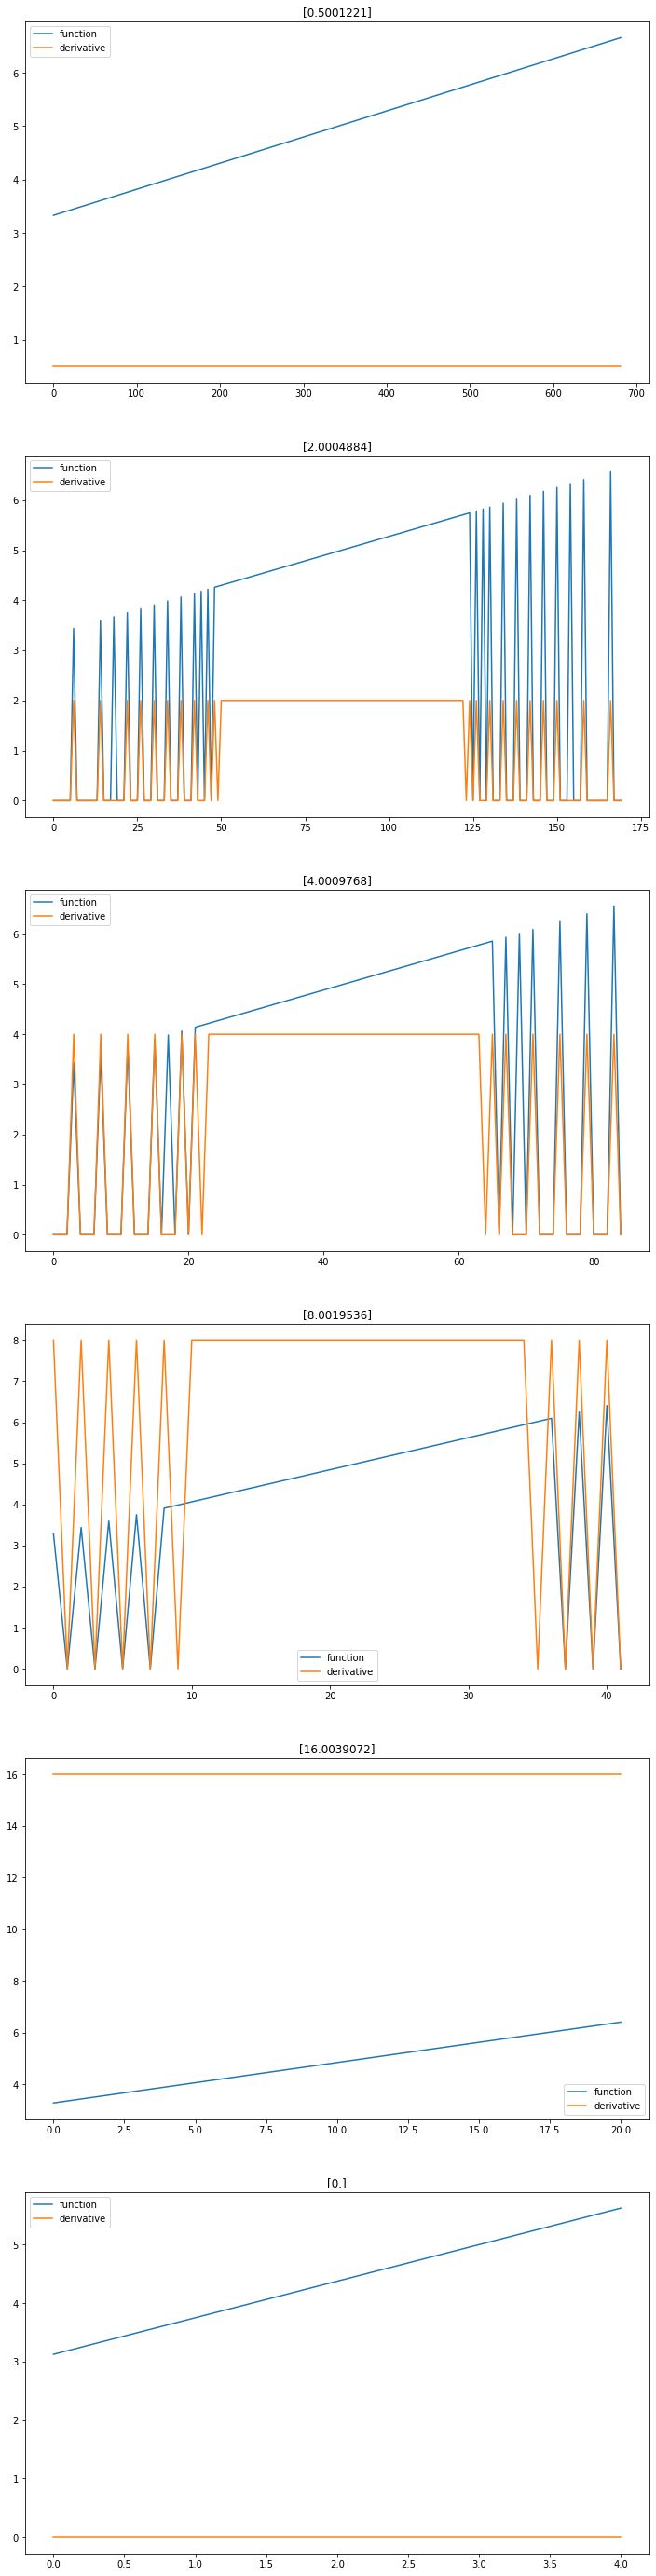

In [18]:
x_ = np.arange(0., 10.001, 10./ 4095.)
func = lambda x: (np.sin(100.*x)*0. + \
                  np.exp(- 25. * ((x-5.)**2) )).astype(np.float64)
y0_ = func(x_).astype(np.float64)
y_ = copy.deepcopy(y0_)
func_diff = lambda x: x

jlvl = 8
order_p = 3
order_u = 3
der_order=3
L = np.ones((len(y_),), dtype=bool)
ende_ = 1+8*2.**(jlvl-1)
h = 10. / (ende_-ende_%2)
errs_1 = []

fig, axs = plt.subplots(6, figsize=(12,50))
for e0,eps in enumerate([0., 0.00001, 0.0001, 0.001, 0.01, 0.1]):
    #for eps in [0.01, 0.1]:
    eps0 = np.max(np.abs(y_)) * eps
    y, df, d2f = calculations(y_, L, jlvl, order_p, order_u, \
                          der_order, eps0, func_diff, \
                              copy.deepcopy(x_))
    axs[e0].plot(y[int(len(df)/3): 2*int(len(df)/3)])
    axs[e0].plot(df[int(len(df)/3): 2*int(len(df)/3)])
    #print("uni", np.unique(df[int(len(df)/2)]))
    axs[e0].set_title(str(np.unique(df[int(len(df)/2)])))
    
    #plt.plot(d2f)
    #plt.ylim(-0.1, 3)
    #plt.show()
    axs[e0].legend(["function", "derivative"])
plt.savefig("/home/alex/derivative.pdf")